In [1]:
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
from tqdm.notebook import tqdm, trange  # Use tqdm.notebook for Jupyter compatibility
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import time
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import optuna
import requests

# Configuration Section
config = {
    'random_seed': 42,
    'np_seed': 0,
    'torch_seed': 0,
    'torch_manual_seed': 2147483647,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'batch_size': 64,
    'num_workers': 4,
    'num_epochs': 10,
    'img_size': (216, 8),
    'patch_size': (4, 2),  # Adjusted patch size to 4x2
    'embed_dim': 128,
    'depth': 12,
    'num_heads': 4,
    'learning_rate': 0.001,
    'optimizer': 'adam',  # Options: 'adam', 'sgd', etc.
    'loss_function': 'mse',  # Options: 'mse', 'mae', etc.
    'print_interval': 100,  # Print loss every 100 batches
    'num_samples': 100,  # Number of samples for importance analysis
    'log_dir': './logs',  # Directory for TensorBoard logs
    'scheduler_step_size': 5,  # Decrease LR every 5 epochs
    'scheduler_gamma': 0.1,  # Decrease LR by a factor of 0.1
    'pushover_user_key': 'uzt44t3bkmhyujr3c4mna7bna9pik6',
    'pushover_api_token': 'a28vox7ixsnxcf853x6yta2kqfg93z',
}

# Generate a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Format the run name
run_name = f"run_{timestamp}_opt_{config['optimizer']}_loss_{config['loss_function']}_lr_{config['learning_rate']}"

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=f"{config['log_dir']}/{run_name}")

# Setting the seeds for reproducibility
np.random.seed(config['np_seed'])
torch.manual_seed(config['torch_seed'])
random.seed(config['random_seed'])
g = torch.Generator().manual_seed(config['torch_manual_seed'])  # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check for device
device = config['device']
print("Device:", device)

def get_file_path(file_name):
    """
    Returns the file path based on the operating system.
    """
    if sys.platform.startswith('win'):
        # Windows path
        base_path = r'C:\path\to\windows\directory'
    elif sys.platform.startswith('linux') or sys.platform.startswith('darwin'):
        # Linux or MacOS path
        base_path = r'/home/jiztom/PycharmProjects/image-based-transformer/Data/CropYield/Cleaned/Cleaned'
    else:
        raise Exception("Unsupported operating system")

    return os.path.join(base_path, file_name)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # Change shape to (batch_size, num_patches, embed_dim)
        return x

class CustomTransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super(CustomTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src
        for mod in self.layers:
            output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
        if self.norm is not None:
            output = self.norm(output)
        return output

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, depth, num_heads):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)  # in_channels set to 1 for grayscale
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = CustomTransformerEncoder(encoder_layer, num_layers=depth)
        
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1)  # Output a single value for regression
        )

    def forward(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer_encoder(x)
        x = self.regression_head(x[:, 0])
        return x

    def get_attention_maps(self, x):
        x = self.patch_embed(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        attention_maps = []
        for layer in self.transformer_encoder.layers:
            x = layer.norm1(x)
            attention = layer.self_attn(x, x, x, need_weights=True)[1]
            attention_maps.append(attention.detach().cpu())
            x = layer.self_attn(x, x, x)[0] + x
            x = layer.norm2(x)
            x = layer.linear2(layer.dropout(layer.activation(layer.linear1(x)))) + x
        return attention_maps

class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data_tensor = data_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        sample = self.data_tensor[idx]
        label = self.labels_tensor[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Function to pad the image to the nearest multiple of patch_size_h and patch_size_w
def pad_image(image, patch_size_h, patch_size_w):
    B, C, H, W = image.shape
    pad_h = (patch_size_h - (H % patch_size_h)) % patch_size_h
    pad_w = (patch_size_w - (W % patch_size_w)) % patch_size_w

    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_image = F.pad(image, padding)
    return padded_image

# Define any required transformations
transform = transforms.Compose([
    # Add any transformations you need here
])

# Example usage
train_norm_file = 'norm_train_02292024.npy'
train_yield_file = 'norm_yield_train.npy'

train_norm_path = get_file_path(train_norm_file)
train_yield_path = get_file_path(train_yield_file)

# Load and preprocess data
data = np.load(train_norm_path)
data_tensor = torch.from_numpy(data).float()  # Convert to float
data_tensor = data_tensor.permute(2, 1, 0)
data_tensor = data_tensor.unsqueeze(1)
data_tensor = pad_image(data_tensor, config['patch_size'][0], config['patch_size'][1])  # Pad to [batch_size, 1, 216, 8]

labels = np.load(train_yield_path)
label_tensor = torch.from_numpy(labels).float()  # Convert to float

# Split the data into training, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data_tensor, label_tensor, test_size=0.4, random_state=config['random_seed'])
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=config['random_seed'])

train_dataset = CustomTensorDataset(data_tensor=train_data, labels_tensor=train_labels, transform=transform)
val_dataset = CustomTensorDataset(data_tensor=val_data, labels_tensor=val_labels, transform=transform)
test_dataset = CustomTensorDataset(data_tensor=test_data, labels_tensor=test_labels, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], generator=g)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], generator=g)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], generator=g)

# Enable Optuna verbose logging
optuna.logging.set_verbosity(optuna.logging.DEBUG)

class TQDMProgressBar:
    def __init__(self, total_trials):
        self.pbar = tqdm(total=total_trials, desc="Optuna Trials", position=0, leave=True)

    def __call__(self, study, trial):
        self.pbar.update(1)
        self.pbar.set_postfix({
            "Best Value": study.best_value,
            "Current Trial": trial.number,
            "Current Value": trial.value
        })

    def close(self):
        self.pbar.close()

# Optuna objective function with detailed progress reporting
def objective(trial):
    val_loss = 0.0
    depth = trial.suggest_int('depth', 6, 24)
    num_heads = trial.suggest_int('num_heads', 4, 16)
    embed_dim = trial.suggest_categorical('embed_dim', [64, 128, 256, 512])  # Updated to ensure divisibility

    # Ensure embed_dim is divisible by num_heads
    while embed_dim % num_heads != 0:
        num_heads = trial.suggest_int('num_heads', 4, 16)

    model = VisionTransformer(
        img_size=config['img_size'],
        patch_size=config['patch_size'],
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads
    ).to(config['device'])

    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Initialize the scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config['scheduler_step_size'], gamma=config['scheduler_gamma'])

    criterion = nn.MSELoss()

    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
    val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])

    for epoch in range(10):  # Use fewer epochs for quicker tuning
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_dataloader, desc=f"Training Trial {trial.number}, Epoch {epoch+1}", leave=False):
            inputs, targets = inputs.to(config['device']), targets.to(config['device'])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_dataloader)
        trial.report(avg_train_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(val_dataloader, desc=f"Validation Trial {trial.number}, Epoch {epoch+1}", leave=False):
                inputs, targets = inputs.to(config['device']), targets.to(config['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        trial.report(avg_val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Step the scheduler
        scheduler.step()

    return avg_val_loss

# Create TQDM progress bar
tqdm_callback = TQDMProgressBar(total_trials=50)

# Set the study name
study_name = "vision_transformer_optimization"

# Execute the hyperparameter search with the TQDM progress bar callback
study = optuna.create_study(study_name=study_name, direction='minimize')
study.optimize(objective, n_trials=50, callbacks=[tqdm_callback])

# Close the progress bar
tqdm_callback.close()

print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Set the best parameters from the study
best_params = trial.params

# Initialize the final model with the best parameters
model = VisionTransformer(
    img_size=config['img_size'],
    patch_size=config['patch_size'],
    embed_dim=best_params['embed_dim'],
    depth=best_params['depth'],
    num_heads=best_params['num_heads']
).to(config['device'])

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
else:
    optimizer = optim.SGD(model.parameters(), lr=best_params['lr'])

# Initialize the scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config['scheduler_step_size'], gamma=config['scheduler_gamma'])

criterion = nn.MSELoss()

# Function to send Pushover notification
def send_pushover_notification(user_key, api_token, message):
    url = 'https://api.pushover.net/1/messages.json'
    data = {
        'token': api_token,
        'user': user_key,
        'message': message
    }
    response = requests.post(url, data=data)
    if response.status_code == 200:
        print("Notification sent successfully!")
    else:
        print(f"Failed to send notification: {response.text}")

# Training loop with the best parameters
num_epochs = config['num_epochs']
prev_val_loss = float('inf')

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (inputs, targets) in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        inputs, targets = inputs.to(config['device']), targets.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % config['print_interval'] == 0:
            tqdm.write(f"  Batch {i+1}/{len(train_dataloader)}, Training Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_dataloader)
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_dataloader, desc="Validation", leave=False)):
            inputs, targets = inputs.to(config['device']), targets.to(config['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            if (i + 1) % config['print_interval'] == 0:
                tqdm.write(f"  Batch {i+1}/{len(val_dataloader)}, Validation Loss: {loss.item():.4f}")
    
    avg_val_loss = val_loss / len(val_dataloader)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    gain = prev_val_loss - avg_val_loss
    prev_val_loss = avg_val_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Gain: {gain:.4f}")

    # Step the scheduler
    scheduler.step()

# Function to convert seconds to hours, minutes, and seconds
def convert_seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return hours, minutes, seconds


end_time = time.time()
total_time = end_time - start_time
hours, minutes, seconds = convert_seconds_to_hms(total_time)
print(f"Total training time: {hours} hours, {minutes} minutes, {seconds} seconds")

# Send notification when training is complete
send_pushover_notification(config['pushover_user_key'], config['pushover_api_token'], f'Training completed in {hours} hours, {minutes} minutes, {seconds} seconds.')

# Testing loop
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader, desc="Testing", leave=False):
        inputs, targets = inputs.to(config['device']), targets.to(config['device'])
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        predictions.append(outputs.cpu().numpy())

avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')
writer.add_scalar('Loss/Test', avg_test_loss)

# Close the TensorBoard writer
writer.close()

# Select random sample of 100 datapoints for attention analysis
np.random.seed(config['random_seed'])
random_indices = np.random.choice(len(test_dataset), config['num_samples'], replace=False)
random_sample = Subset(test_dataset, random_indices)

# Initialize accumulators for attention maps
accumulated_attention_maps = None

# Collect attention maps
for i in tqdm(range(len(random_sample)), desc="Collecting Attention Maps"):
    image, label = random_sample[i]
    image = image.unsqueeze(0).to(config['device'])
    attention_maps = model.get_attention_maps(image)
    
    if accumulated_attention_maps is None:
        accumulated_attention_maps = [attn_map[0, 0, 1:].reshape(-1).cpu().numpy() for attn_map in attention_maps]
    else:
        for j in range(len(attention_maps)):
            accumulated_attention_maps[j] += attention_maps[j][0, 0, 1:].reshape(-1).cpu().numpy()

# Normalize accumulated attention maps
for j in range(len(accumulated_attention_maps)):
    accumulated_attention_maps[j] /= config['num_samples']

# Visualize aggregated attention maps on a representative image
single_image, _ = test_dataset[random_indices[0]]
single_image = single_image.unsqueeze(0).to(config['device'])

def plot_aggregated_attention_maps(image, accumulated_attention_maps, patch_size):
    image = image.squeeze(0).cpu().numpy()  # Remove batch dimension
    image = image.transpose(1, 2, 0).squeeze()  # Change shape from [1, H, W] to [H, W]

    fig, axes = plt.subplots(1, len(accumulated_attention_maps), figsize=(20, 10))
    num_patches = (image.shape[0] // patch_size[0]) * (image.shape[1] // patch_size[1])
    for i, attn_map in enumerate(accumulated_attention_maps):
        attn_map = attn_map.reshape(image.shape[0] // patch_size[0], image.shape[1] // patch_size[1])
        attn_map = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=image.shape, mode='bilinear').squeeze().cpu().numpy()
        
        # Normalize attention map for better visualization
        attn_map /= attn_map.max()
        
        # Overlay the attention map on the original image
        axes[i].imshow(image, cmap='gray', alpha=0.5)
        sns.heatmap(attn_map, ax=axes[i], cbar=False, alpha=0.5)
        axes[i].set_title(f'Layer {i+1}')
        
        # Draw patch borders
        for y in range(0, image.shape[0], patch_size[0]):
            for x in range(0, image.shape[1], patch_size[1]):
                rect = patches.Rectangle((x, y), patch_size[1], patch_size[0], linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
                
    plt.show()

# Example usage
plot_aggregated_attention_maps(single_image, accumulated_attention_maps, config['patch_size'])

def filter_state_dict(state_dict, layers_to_keep):
    """Filter the state dictionary to only include layers to keep."""
    new_state_dict = {}
    for key, value in state_dict.items():
        parts = key.split('.')
        if len(parts) > 3 and parts[2].isdigit():
            layer_num = int(parts[2])
            if layer_num in layers_to_keep:
                new_state_dict[key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

def ablation_study(model, dataloader, criterion, device):
    """Conducts an ablation study by evaluating the model with specific layers excluded."""
    original_state_dict = model.state_dict()
    performance_metrics = {}
    
    for layer in range(len(model.transformer_encoder.layers)):
        layers_to_keep = [i for i in range(len(model.transformer_encoder.layers)) if i != layer]
        new_state_dict = filter_state_dict(original_state_dict, layers_to_keep)
        
        model.load_state_dict(new_state_dict, strict=False)
        
        # Create a new custom encoder with the remaining layers
        new_layers = nn.ModuleList([model.transformer_encoder.layers[i] for i in layers_to_keep])
        custom_encoder = CustomTransformerEncoder(new_layers[0], len(new_layers))
        model.transformer_encoder = custom_encoder
        
        # Evaluate the model
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item()
        
        avg_loss = running_loss / len(dataloader)
        performance_metrics[f'Layer_{layer}'] = avg_loss
        print(f'Layer {layer} excluded: Avg Loss = {avg_loss}')
    
    return performance_metrics

# Conduct ablation study
performance_metrics = ablation_study(model, val_dataloader, criterion, config['device'])

def plot_combined_attention_map(image, accumulated_attention_maps, patch_size):
    # Debugging: Print shapes of accumulated attention maps
    print("Accumulated attention maps:")
    for i, attn_map in enumerate(accumulated_attention_maps):
        print(f"Shape of attention map {i}: {attn_map.shape}")

    if not accumulated_attention_maps:
        raise ValueError("Accumulated attention maps are empty")

    # Aggregate the attention maps
    combined_attention_map = np.zeros_like(accumulated_attention_maps[0])

    for attn_map in accumulated_attention_maps:
        combined_attention_map += attn_map

    combined_attention_map /= len(accumulated_attention_maps)

    # Reshape to match image dimensions
    num_patches_h = image.shape[0] // patch_size[0]
    num_patches_w = image.shape[1] // patch_size[1]
    combined_attention_map = combined_attention_map.reshape(num_patches_h, num_patches_w)

    # Normalize combined attention map
    combined_attention_map = F.interpolate(torch.tensor(combined_attention_map).unsqueeze(0).unsqueeze(0), size=(image.shape[0], image.shape[1]), mode='nearest').squeeze().cpu().numpy()
    combined_attention_map /= combined_attention_map.max()

    # Transpose the combined attention map
    combined_attention_map = combined_attention_map.T

    # Plot the combined attention map
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size

    sns.heatmap(combined_attention_map, ax=ax, cbar=False, square=True, linewidths=0.5, linecolor='black', cmap='viridis')  # Removed color scale
    ax.set_title('Combined Attention Map', fontsize=20)  # Increased font size
    ax.invert_yaxis()  # Invert y-axis

    # Draw patch borders
    for y in range(0, combined_attention_map.shape[0], patch_size[0]):
        for x in range(0, combined_attention_map.shape[1], patch_size[1]):
            rect = patches.Rectangle((x, y), patch_size[1], patch_size[0], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.show()

# Example usage
single_image_np = single_image.squeeze(0).cpu().numpy()  # Remove batch dimension if it's there
plot_combined_attention_map(single_image_np, accumulated_attention_maps, config['patch_size'])

# Release GPU resources
del model
torch.cuda.empty_cache()
# 
# Send notification when everything is complete
send_pushover_notification(config['pushover_user_key'], config['pushover_api_token'], 'Training and evaluation process completed successfully.')


Device: cuda:0


Optuna Trials:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-07-16 14:06:49,690] A new study created in memory with name: vision_transformer_optimization
[W 2024-07-16 14:12:27,553] Trial 0 failed with parameters: {'depth': 17, 'num_heads': 12, 'embed_dim': 512} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jiztom/anaconda3/envs/image-based-transformer/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_7411/2605267973.py", line 246, in objective
    num_heads = trial.suggest_int('num_heads', 4, 16)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jiztom/anaconda3/envs/image-based-transformer/lib/python3.11/site-packages/optuna/_convert_positional_args.py", line 56, in converter_wrapper
    positional_arg_names = _get_positional_arg_names(func)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jiztom/anaconda3/envs/image-ba

KeyboardInterrupt: 

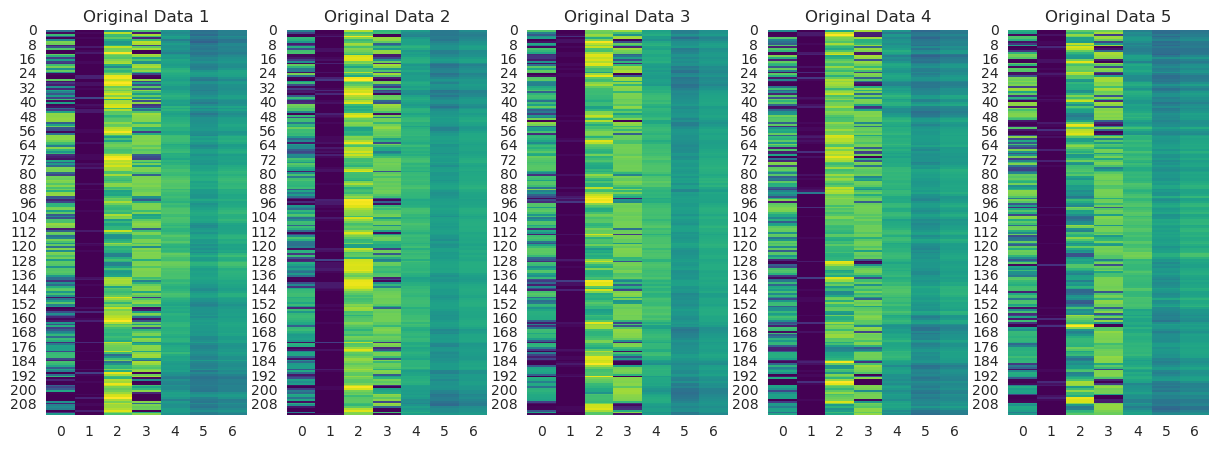

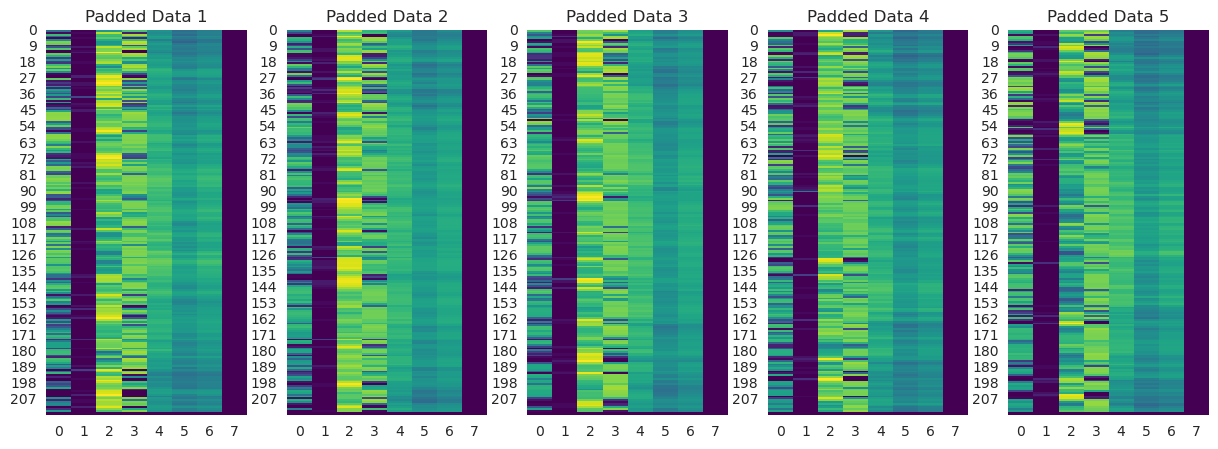

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize data
def visualize_data(data_tensor, title):
    fig, axes = plt.subplots(1, len(data_tensor), figsize=(15, 5))
    for i, data in enumerate(data_tensor):
        data = data.squeeze().cpu().numpy()
        sns.heatmap(data, ax=axes[i], cmap='viridis', cbar=False)
        axes[i].set_title(f'{title} {i+1}')
    plt.show()

# Example data
data = np.load(config['data_norm_path'])
data_tensor = torch.from_numpy(data).float()  # Convert to float
data_tensor = data_tensor.permute(2, 1, 0)
data_tensor = data_tensor.unsqueeze(1)

# Visualize data before padding
visualize_data(data_tensor[:5], 'Original Data')

# Function to pad the image to the nearest multiple of patch_size_h and patch_size_w
def pad_image(image, patch_size_h, patch_size_w):
    B, C, H, W = image.shape
    pad_h = (patch_size_h - (H % patch_size_h)) % patch_size_h
    pad_w = (patch_size_w - (W % patch_size_w)) % patch_size_w

    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_image = F.pad(image, padding)
    return padded_image

# Pad the data
padded_data_tensor = pad_image(data_tensor, config['patch_size'][0], config['patch_size'][1])

# Visualize data after padding
visualize_data(padded_data_tensor[:5], 'Padded Data')


Accumulated attention maps:
Shape of attention map 0: (216,)
Shape of attention map 1: (216,)
Shape of attention map 2: (216,)
Shape of attention map 3: (216,)
Shape of attention map 4: (216,)
Shape of attention map 5: (216,)
Shape of attention map 6: (216,)
Shape of attention map 7: (216,)
Shape of attention map 8: (216,)
Shape of attention map 9: (216,)
Shape of attention map 10: (216,)
Shape of attention map 11: (216,)


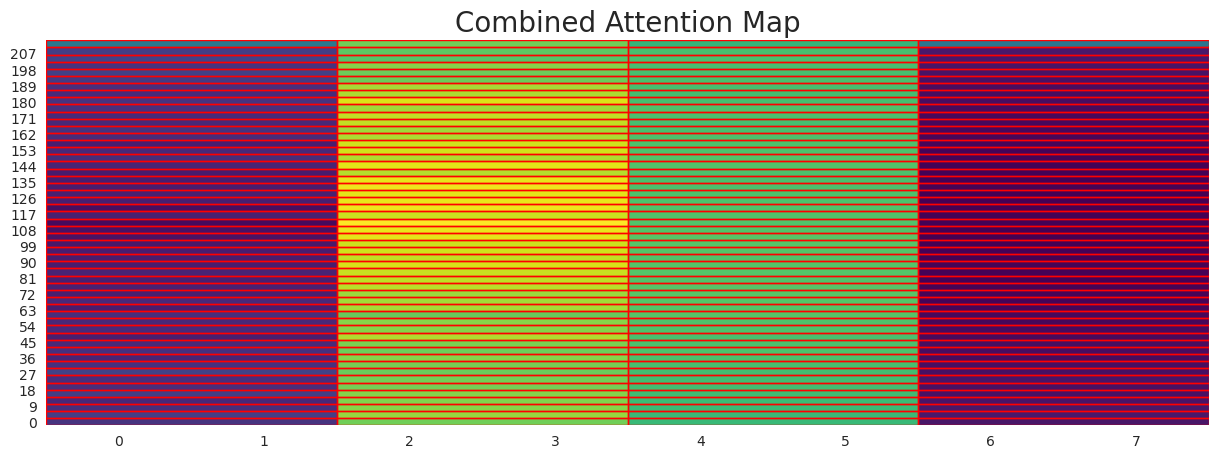

In [36]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

def plot_combined_attention_map(image, accumulated_attention_maps, patch_size):
    # Debugging: Print shapes of accumulated attention maps
    print("Accumulated attention maps:")
    for i, attn_map in enumerate(accumulated_attention_maps):
        print(f"Shape of attention map {i}: {attn_map.shape}")

    if not accumulated_attention_maps:
        raise ValueError("Accumulated attention maps are empty")

    # Aggregate the attention maps
    combined_attention_map = np.zeros_like(accumulated_attention_maps[0])

    for attn_map in accumulated_attention_maps:
        combined_attention_map += attn_map

    combined_attention_map /= len(accumulated_attention_maps)

    # Reshape to match image dimensions
    num_patches_h = image.shape[0] // patch_size[0]
    num_patches_w = image.shape[1] // patch_size[1]
    combined_attention_map = combined_attention_map.reshape(num_patches_h, num_patches_w)

    # Normalize combined attention map
    combined_attention_map = F.interpolate(torch.tensor(combined_attention_map).unsqueeze(0).unsqueeze(0), size=(image.shape[0], image.shape[1]), mode='nearest').squeeze().cpu().numpy()
    combined_attention_map /= combined_attention_map.max()

    # # Transpose the combined attention map
    # combined_attention_map = combined_attention_map.T

    # Plot the combined attention map
    fig, ax = plt.subplots(figsize=(15, 5))  # Increased figure size
    sns.heatmap(combined_attention_map, ax=ax, cmap='viridis', cbar=False)
    # sns.heatmap(combined_attention_map, ax=ax, cbar=False, square=True, linewidths=0.5, linecolor='black', cmap='viridis')  # Removed color scale
    ax.set_title('Combined Attention Map', fontsize=20)  # Increased font size
    ax.invert_yaxis()  # Invert y-axis

    # Draw patch borders
    for y in range(0, combined_attention_map.shape[0], patch_size[0]):
        for x in range(0, combined_attention_map.shape[1], patch_size[1]):
            rect = patches.Rectangle((x, y), patch_size[1], patch_size[0], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.show()

# Example usage
single_image_np = single_image.squeeze(0)  # Remove batch dimension if it's there
plot_combined_attention_map(single_image_np, accumulated_attention_maps, config['patch_size'])
